# Autoencoders and Variational Autoencoders



**Author**: Matthew Stewart


<hr style="height:2pt">

In [1]:
## load the libraries 
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.metrics import *
from keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from keras.preprocessing import image
from keras import datasets

from keras import backend as K

from imgaug import augmenters
import matplotlib.pyplot as plt
plt.gray()

Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

## Part 1: Data

### Reading data

Download the data given at the following link: <insert_link>. Use pandas and numpy to read in the data as a matrix

### Visualizing Samples

Visualize 10 images from dataset

## Part 3: Exercise: Denoising noisy documents

In [2]:
# # !pwd

# !unzip ./21-MAI.zip

In [3]:
TRAIN_IMAGES = glob.glob('./21-MAI/Train/*.jpg')
CLEAN_IMAGES = glob.glob('./21-MAI/original/*.jpg')
TEST_IMAGES = glob.glob('./21-MAI/test/*.*')

(788, 1024)


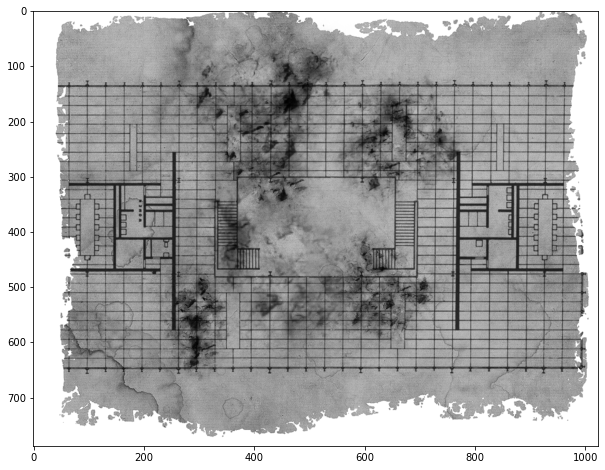

In [4]:
plt.figure(figsize=(20,8))
img = cv2.imread('./21-MAI/Train/0.jpg', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

(788, 1024)


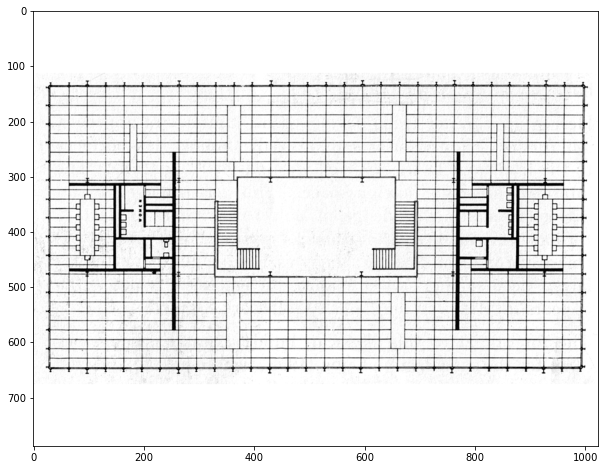

In [5]:
plt.figure(figsize=(20,8))
img = cv2.imread('./21-MAI/original/0.jpg', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

In [6]:
def load_image(path):
    image_list = np.zeros((len(path), 768, 1024, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, grayscale=True, target_size=(768, 1024))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list

x_train = load_image(TRAIN_IMAGES)
y_train = load_image(CLEAN_IMAGES)
x_test = load_image(TEST_IMAGES)

print(x_train.shape, x_test.shape,y_train.shape)

(180, 768, 1024, 1) (18, 768, 1024, 1) (180, 768, 1024, 1)


In [7]:
x_train.shape

(180, 768, 1024, 1)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
print(x_train.shape, x_val.shape)

(144, 768, 1024, 1) (36, 768, 1024, 1)


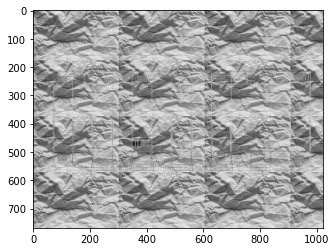

In [9]:
plt.imshow(x_train[10, :, :, 0])

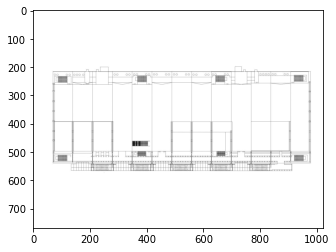

In [10]:
plt.imshow(y_train[10, :, :, 0])

In [11]:
input_layer = Input(shape=(768, 1024, 1))
        
# # encoder
encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoder = MaxPooling2D( (2, 2), padding='same')(encoder)
# encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
# encoder = MaxPooling2D( (2, 2), padding='same')(encoder)
# encoder = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder)
# encoder = MaxPooling2D((2, 2), padding='same')(encoder)

# decoder
# decoder = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder)
# decoder = UpSampling2D((2, 2))(decoder)
# decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
# decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(64, (3, 3), activation='relu',padding='same')(encoder)
decoder = UpSampling2D((2, 2))(decoder)
output_layer = Conv2D(1, (3, 3), activation='sigmoid',padding='same')(decoder)

ae = Model(input_layer, output_layer)

In [20]:
ae.compile(loss='mse'', optimizer=Adam(lr=0.001))
# ae.compile(optimizer='adam',loss='mse')
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768, 1024, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 768, 1024, 64)     640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 384, 512, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 384, 512, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 192, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 192, 256, 32)      9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 384, 512, 32)      0     

In [21]:
batch_size = 16
epochs = 500

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1, mode='auto')
history = ae.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=[early_stopping])
# history = ae.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/500


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv2d/Conv2D (defined at <ipython-input-21-ab9ca0e0882a>:5) ]] [Op:__inference_train_function_860]

Function call stack:
train_function


In [ ]:
preds = ae.predict(x_test)

In [ ]:
n = 17

headPath = "/content/drive/MyDrive/21-ManufactureAI/Result1/"
for n in range(12):
  preds_0 = preds[n] * 255.0
  preds_0 = preds_0.reshape(768, 1024)
  x_test_0 = x_test[n] * 255.0
  x_test_0 = x_test_0.reshape(768, 1024)
  plt.imshow(x_test_0, cmap='gray')
  plt.savefig(str(n)+"compare.png",dpi=300)
  plt.imshow(preds_0, cmap='gray')
  plt.savefig(str(n)+"result.png",dpi=300)

## Part 4: Generating New Fashion using VAEs

### Understanding VAEs

!["VAE"](http://www.cvc.uab.es/people/joans/slides_tensorflow/tensorflow_html/vae_files/ae.png)

### Reset data

In [ ]:
### read dataset 
train = pd.read_csv("fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

## create train and validation datasets
train_x, val_x = train_test_split(train_x, test_size=0.2)

In [ ]:
## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

### Setup Encoder Neural Network

Try different number of hidden layers, nodes?

In [ ]:
import keras.backend as K

In [ ]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

input_img = Input(shape=(784,), name="input")
x = Dense(512, activation='relu', name="intermediate_encoder")(input_img)
x = Dense(2, activation='relu', name="latent_encoder")(x)

z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

In [ ]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

In [ ]:
# decoder takes the latent distribution sample as input
decoder_input = Input((2,), name="input_decoder")

x = Dense(512, activation='relu', name="intermediate_decoder", input_shape=(2,))(decoder_input)

# Expand to 784 total pixels
x = Dense(784, activation='sigmoid', name="original_decoder")(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [ ]:
decoder.summary()

In [ ]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        return xent_loss

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [ ]:
z_decoded

In [ ]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [ ]:
vae.summary()

In [ ]:
train_x.shape

In [ ]:
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

In [ ]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

In [ ]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()  

In [ ]:
### read dataset 
train = pd.read_csv("fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train[list(train.columns)[0]].values

train_x = train_x/255.
# train_x = train_x.reshape(-1, 28, 28, 1)

# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=train_y, cmap='brg')
plt.colorbar()
plt.show()

## Part 5: Exercise: Generating New Fashion using VAEs: Adding CNNs and KL Divergence Loss

In [ ]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

### Set up sampling function

In [ ]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

### Setup Decoder Neural Network

Try different number of hidden layers, nodes?

In [ ]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

### Set up loss functions

In [ ]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

### Train VAE

In [ ]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [ ]:
vae.summary()

In [ ]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [ ]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,validation_data=(val_x, None))

### Visualize Samples reconstructed by VAE

In [ ]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()  

## TODO:
#### VAE: Visualize latent space

In [ ]:
train = pd.read_csv("fashion-mnist_train.csv")


In [ ]:
### read dataset 
train = pd.read_csv("fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train[list(train.columns)[0]].values

train_x = train_x/255.
train_x = train_x.reshape(-1, 28, 28, 1)

In [ ]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=train_y, cmap='brg')
plt.colorbar()
plt.show()